#Реализовать и обучить (с нуля) СНС для задачи классификации изображений на датасете CIFAR-10

In [2]:
%tensorflow_version 2.x

In [3]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

#### Загрузка и подготовка датасета CIFAR-10

In [4]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()

train_x = train_x.reshape(-1, 32, 32, 3).astype(np.float32) / 255.
test_x = test_x.reshape(-1, 32, 32, 3).astype(np.float32) / 255.

train_y = np.reshape(train_y, (-1)).astype(np.int32)
test_y = np.reshape(test_y, (-1)).astype(np.int32)

print(train_x.shape, train_x.dtype)
print(test_x.shape, test_x.dtype)
print(train_y.shape, train_y.dtype)
print(test_y.shape, test_y.dtype)

170508288/170498071 [==============================] - 12s 0us/step
(50000, 32, 32, 3) float32
(10000, 32, 32, 3) float32
(50000,) int32
(10000,) int32


####Визуализация датасета

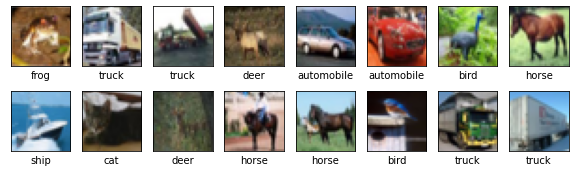

In [5]:
some_samples = train_x[:16, ...]

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

fig = plt.figure(figsize=(10, 6))
for j in range(some_samples.shape[0]):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j,:,:,:])
    plt.xticks([]), plt.yticks([])
    plt.imshow(train_x[j], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_y[j]])
    
plt.show()

####Создание модели CNN

In [6]:
class Model(tf.keras.Model):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')
        self.conv2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')
        self.conv3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')
        self.conv4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')
        self.max_pool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2))
        self.dropout1 = tf.keras.layers.Dropout(0.25)
        self.dropout2 = tf.keras.layers.Dropout(0.25)
        self.dropout3 = tf.keras.layers.Dropout(0.5)
        self.fc1 = tf.keras.layers.Dense(512, activation='relu')
        self.fc2 = tf.keras.layers.Dense(10, activation=None)
        self.flatten = tf.keras.layers.Flatten()
        
    def call(self, inp):

        out = self.conv1(inp)
        out = self.conv2(out)
        out = self.max_pool(out)
        out = self.dropout1(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.max_pool(out)
        out = self.dropout2(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.dropout3(out)
        out = self.fc2(out)
        
        return out
    
model = Model()

####Подготовка к обучению

In [7]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="auto", name="sparse_categorical_crossentropy"
)

model.compile(
    optimizer="Adam", loss=loss, metrics=["accuracy"]
)

call_back = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=1,
    mode="auto",
    restore_best_weights=True,
)

####Обучение модели

In [8]:
model.fit(train_x, train_y, 
            batch_size=32,
            epochs=40,
            validation_data=(test_x, test_y),
            callbacks=call_back
         )

Epoch 1/40
1563/1563 [==============================] - 49s 12ms/step - loss: 1.4847 - accuracy: 0.4581 - val_loss: 1.1076 - val_accuracy: 0.5979
Epoch 2/40
1563/1563 [==============================] - 19s 12ms/step - loss: 1.0625 - accuracy: 0.6235 - val_loss: 0.9061 - val_accuracy: 0.6786
Epoch 3/40
1563/1563 [==============================] - 19s 12ms/step - loss: 0.9163 - accuracy: 0.6787 - val_loss: 0.8018 - val_accuracy: 0.7216
Epoch 4/40
1563/1563 [==============================] - 19s 12ms/step - loss: 0.8236 - accuracy: 0.7109 - val_loss: 0.7822 - val_accuracy: 0.7307
Epoch 5/40
1563/1563 [==============================] - 19s 12ms/step - loss: 0.7543 - accuracy: 0.7343 - val_loss: 0.7617 - val_accuracy: 0.7356
Epoch 6/40
1563/1563 [==============================] - 19s 12ms/step - loss: 0.7058 - accuracy: 0.7524 - val_loss: 0.7031 - val_accuracy: 0.7603
Epoch 7/40
1563/1563 [==============================] - 19s 12ms/step - loss: 0.6691 - accuracy: 0.7661 - val_loss: 0.6775 -

####Оценка качества модели

In [9]:
_, accuracy_value = model.evaluate(x=test_x[:], y=test_y[:], batch_size=12)
print("Final Accuracy: %5.2f %%" % (accuracy_value * 100))

834/834 [==============================] - 4s 4ms/step - loss: 0.6502 - accuracy: 0.7829
Final Accuracy: 78.29 %


#### Функция для инференса и отображения результата предсказания

In [10]:
def test_item(sample):
    
    logits = model(sample[None, ...])[0]
    prediction = tf.nn.softmax(logits)
    ans = np.argmax(prediction)
    
    fig = plt.figure(figsize=(12,4))

    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(sample[:,:,:])
    plt.xticks([]), plt.yticks([])

    ax = fig.add_subplot(1, 2, 2)
    bar_list = ax.bar(np.arange(10), prediction, align='center')
    bar_list[ans].set_color('g')
    ax.set_xticks(np.arange(10))
    ax.set_xlim([-1, 10])
    ax.grid(True)

    plt.show()
    
    print('Predicted: {}'.format(ans))

### Запуск предсказания для изображения случайного изображения из CIFAR-10

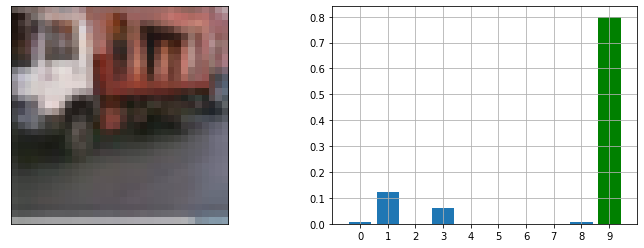

Predicted: 9
True Answer: код 9 класс грузовик


In [13]:
import random
idx = random.randint(0, test_x.shape[0])
sample = test_x[idx, ...]
test_item(sample)

classes=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']
print(f'True Answer: код {test_y[idx]} класс {classes[test_y[idx]]}')